## Should Asset Baskets help a predictive model?
The question that I'm trying to answer with this set of data exploration is whether different asset classes (ids) have very different predictive features. This is to gauge whether a model might benefit by splitting them into baskets of asset classes with similar correlative features.

P.S I'm very very knew to data science, so any tips, tricks and criticisms that you think would be useful for me would be very much appreciated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline

In [2]:
with pd.HDFStore('train.h5','r') as train:
    df = train.get("train")

In [3]:
asset_class = df.groupby('id')
asset_class_count = asset_class.count()

We shouldn't expect asset classes to share predictive features, so let's break them up. We could try to find consistently predictive features (which several posted kernels have done) or try to create separate models for baskets of similar asset classes. The latter option only really makes sense if there are definable categories of asset classes, so we're going to try to find some by seeing if there are patterns in which ones they correlate with.

In [4]:
def get_corr_by_feature(df,num_features=5,min_periods=40):
    columns = df.columns
    y_values = df[columns[-1]]
    features_corr = []
    for col in columns:
        if col != 'timestamp' and col != 'id' and col != "y":
            correlation = df[col].corr(y_values,min_periods = min_periods) ##min_periods helps make sure nothing is highly correlated just because there's so little data
            features_corr.append([col,correlation])
            
    features_series = pd.DataFrame(features_corr,columns = ['Features','Correlation to Y'])
    features_series = features_series.iloc[features_series['Correlation to Y'].abs().sort_values(ascending = False).index]
    return features_series[:num_features]

In [5]:
##Get the top 5 most correlated features by asset class
asset_class_predictors_full = asset_class.apply(get_corr_by_feature,num_features=df.shape[1],min_periods=1)


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


## Using Frequency to Allocate Asset Classes to Baskets
The goal of this kernel is to find some way to basket the asset classes in a logical way. Let's explore and see if we can't come up with a meaningful solution.

### Heatmap for absolute feature correlation to y by ID
Before we get started on building our models, it might be useful just to visualize any features that seem to be consistent. Below, you can see that a few features do seem to be generally useful, which we might include in several of models. 

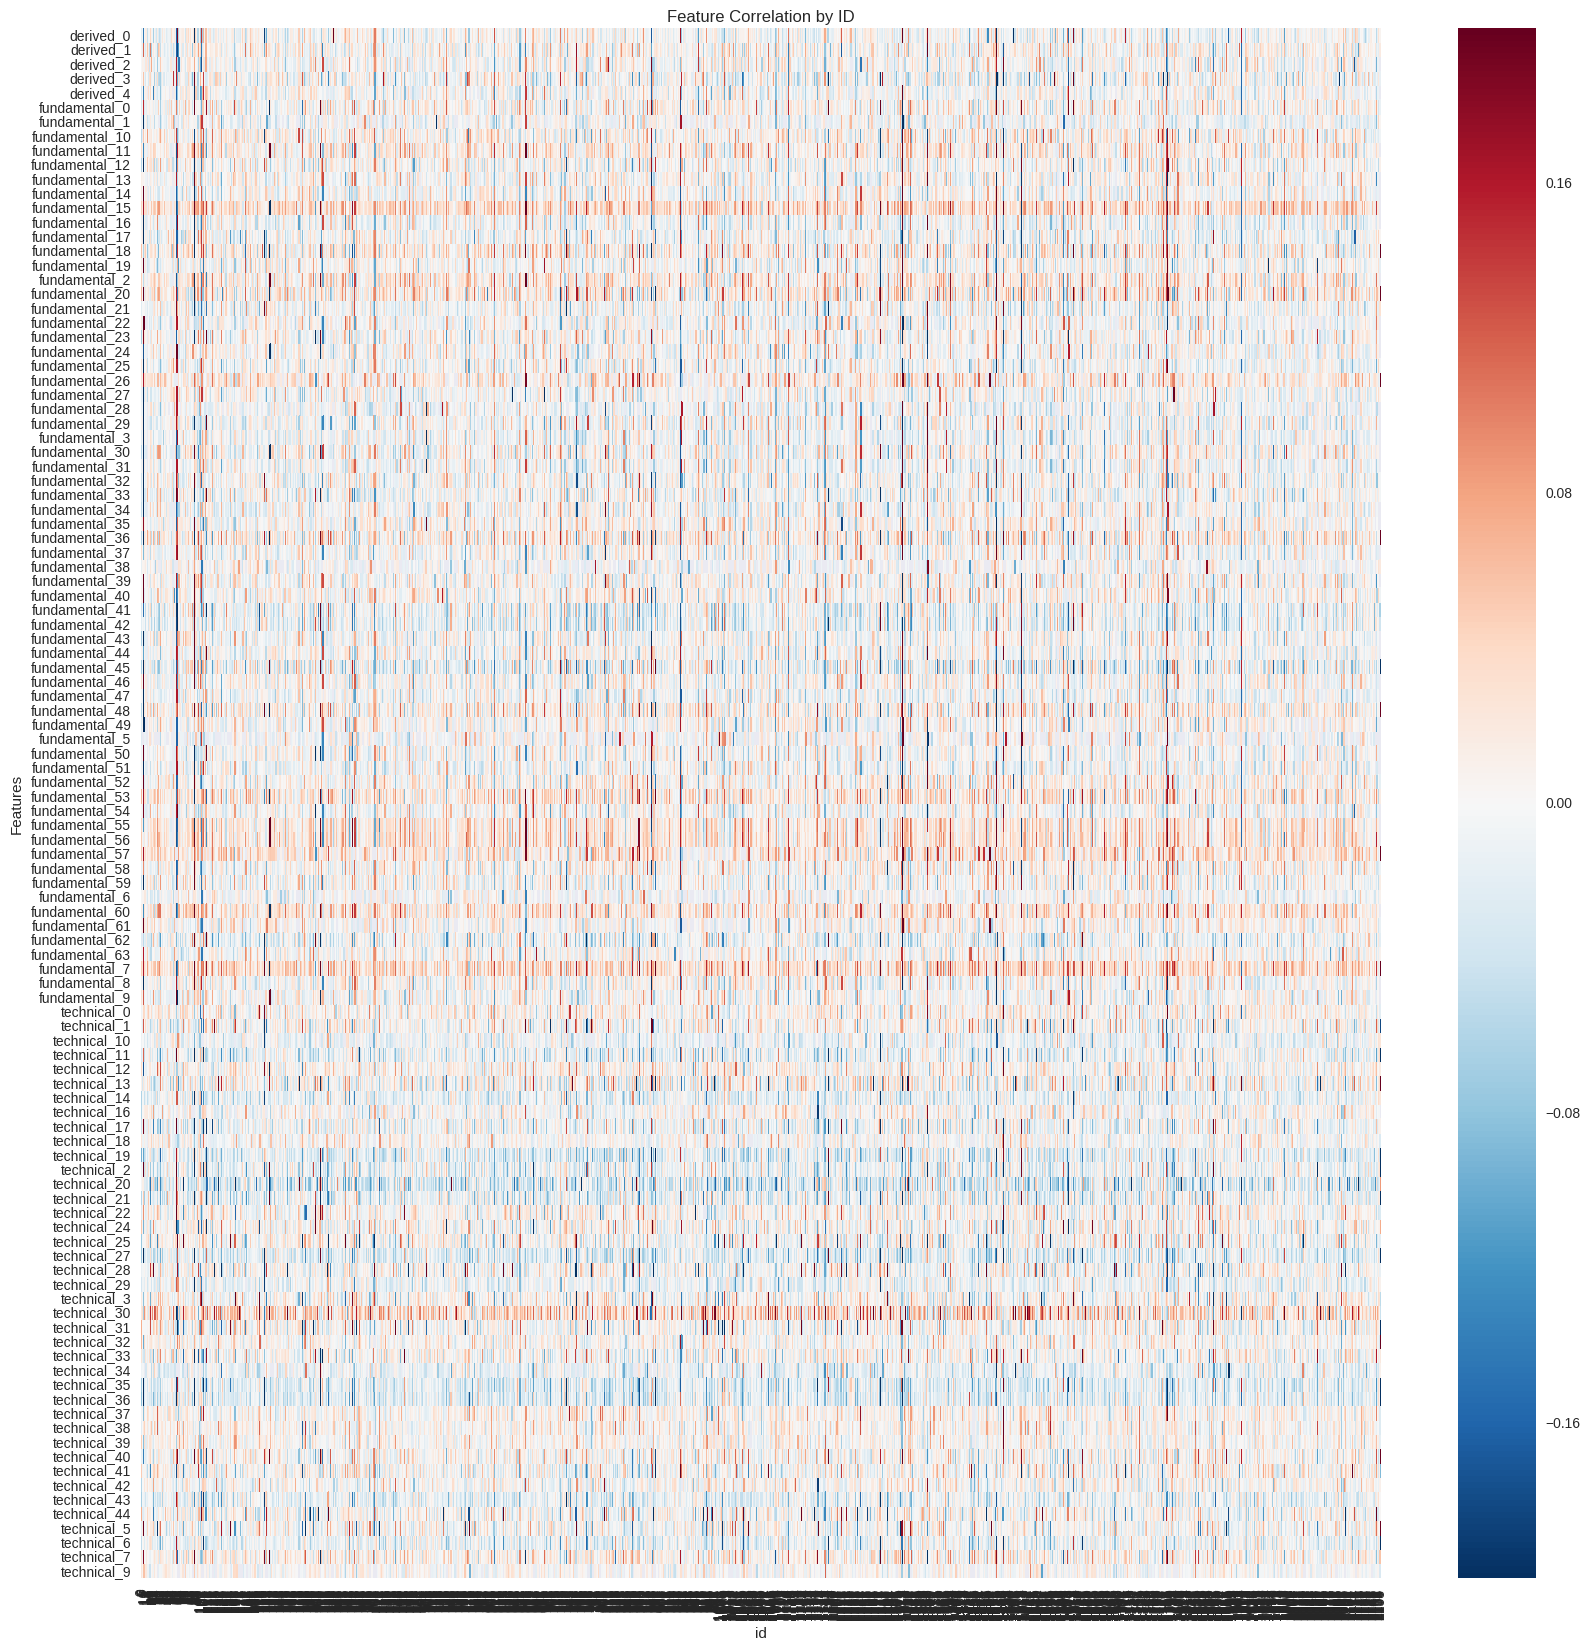

In [6]:
d = asset_class_predictors_full.reset_index().drop(['level_1'],1).sort_values(['id','Features'])
d_pivot = d.pivot(values='Correlation to Y',index='Features',columns='id')
fig = plt.figure(figsize=(20,20))
plt.title('Feature Correlation by ID')


sns.heatmap(d_pivot,vmax=0.2,vmin=-0.2)


It does look as though there are some generally strong features across all asset classes (Technical 30 sticks out).
It still looks like there may be a good deal of variation though. Let's continue on.

### Graphing frequency of feature appearance in top 5
Let's take a look at how many times a given feature is a top 5 predictor of y among asset classes.

In [7]:
num_features = 5 ##We will use the top X features
min_periods = 40 ##We may change later. Helps to protect against strong correlational bias because of a tiny amount of data
maximum_correlative_features_by_class = asset_class.apply(get_corr_by_feature,num_features=num_features,min_periods=min_periods)

Maximum possible value is: 1424


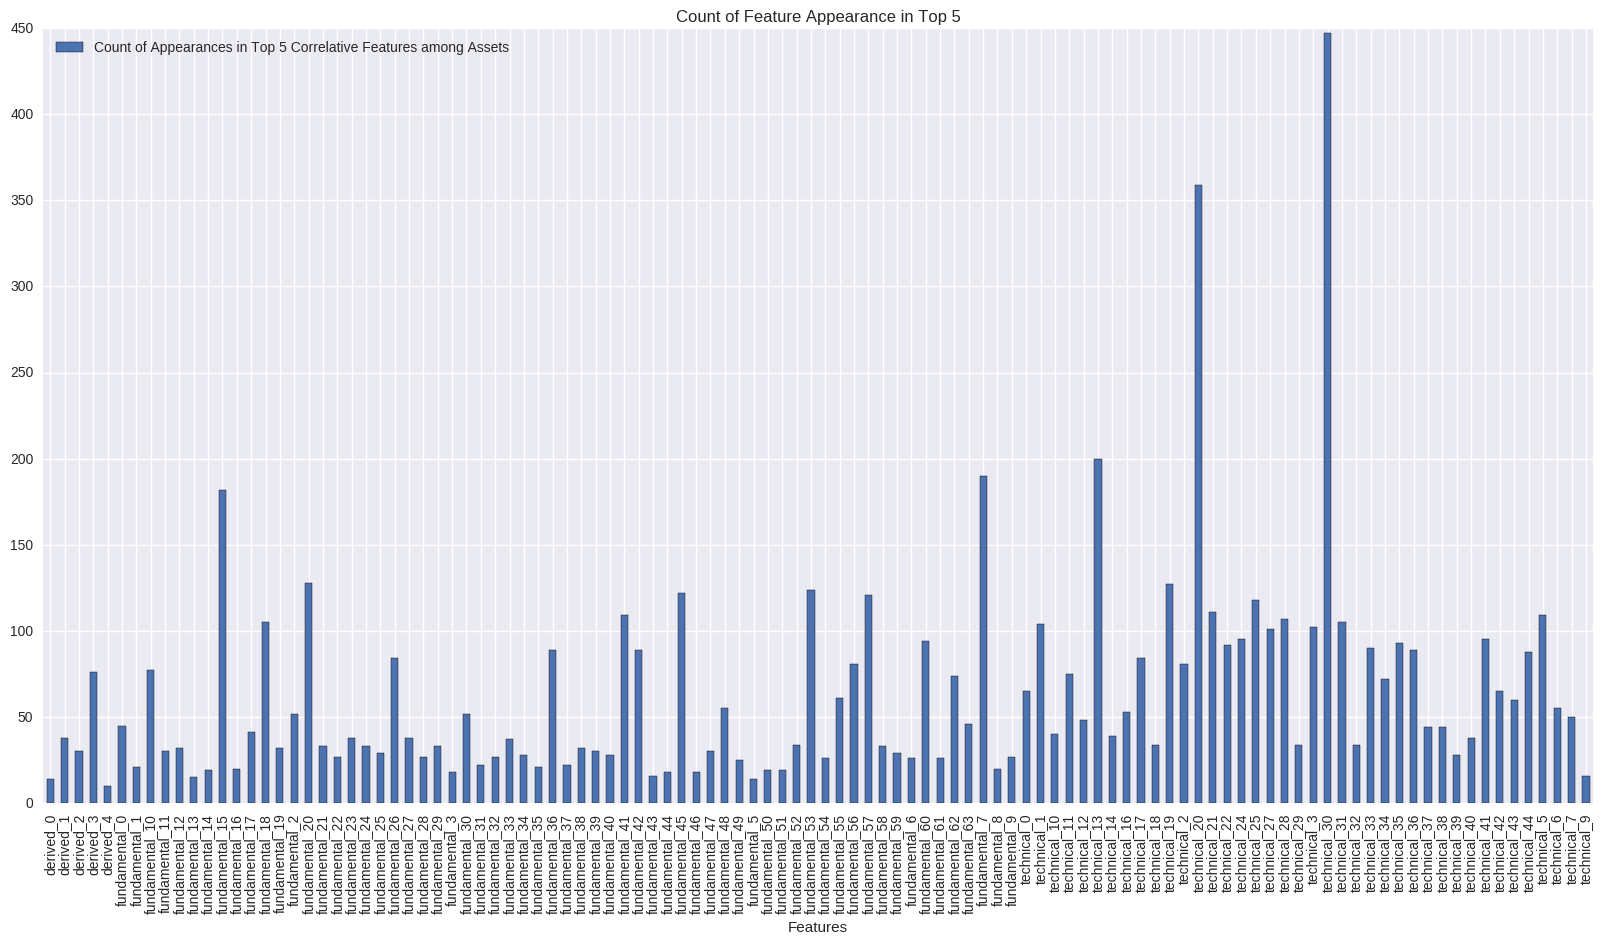

In [8]:
m = maximum_correlative_features_by_class
print("Maximum possible value is: {}".format(len(m.index.levels[0])))
feature_group = m.groupby('Features').count()
feature_group.columns=['Count of Appearances in Top {} Correlative Features among Assets'.format(num_features)]
feature_group.plot(title='Count of Feature Appearance in Top 5',kind='bar',figsize=(20,10))


In [9]:
top_5 = feature_group.sort_values('Count of Appearances in Top {} Correlative Features among Assets'.format(num_features),ascending=False).head()
top_5_features = top_5.index.values
top_5

Count of Appearances in Top 5 Correlative Features among Assets
Features                                                                       
technical_30                                                  447              
technical_20                                                  359              
technical_13                                                  200              
fundamental_7                                                 190              
fundamental_15                                                182

It's pretty clear there are a few winners. Technical 30, technical 20, technical 13, fundamental 7 and fundamental 15 are most commonly in the top 5 for the best correlation score among asset classes.

Let's see what portion of the entire training data set is covered by assets that are relatively highly correlated (I.e in their top 5) with these 5 features.

In [10]:
asset_ids_found = []
for asset_id in m.index.levels[0]:
    for f in top_5_features:
        if (m.loc[asset_id]['Features'] == f).any():
            asset_ids_found.append(asset_id)

In [14]:
#Get the pct of correlated ids
total_asset_classes = len(m.index.levels[0])
correlated_ids_pct = float(len(asset_ids_found))/total_asset_classes

print ("% of IDs whose top 5 predictive features contains one of the general top 5 predictive features: %{:.2f}".format(correlated_ids_pct*100))

% of IDs whose top 5 predictive features contains one of the general top 5 predictive features: %96.77


..That's actually a lot higher than I was expecting. It turns out that if you include the top 5 most frequently highly correlated features, you can cover 97% of asset classes. 

Let's examine how much each feature actually adds to this percentage.

In [15]:
#Let's see what the cumulative % is after adding each feature
labels = [top_5_features]
##This will hold all the asset classes with respect to what feature they were contained in.
cum_ids_found_at_level = [[],[],[],[],[]] ##Five positions
for asset_id in m.index.levels[0]:
    for i in range(len(top_5_features)):
        if (m.loc[asset_id]['Features'] == top_5_features[i]).any():
            cum_ids_found_at_level[i].append(asset_id)
            
pcts_found_at_level = ([float(len(x))/total_asset_classes for x in cum_ids_found_at_level])
cum_pcts_found_at_level = np.cumsum(pcts_found_at_level)

## Plotting asset class coverage gain by feature introduction

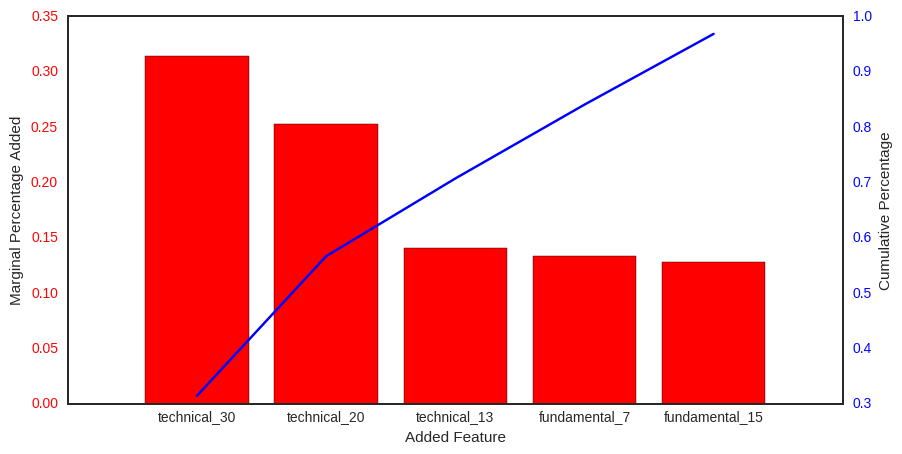

In [16]:
sns.set_style('white')
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.bar([0,1,2,3,4],pcts_found_at_level,color='r',align='center')

ax1.set_xlabel('Added Feature')
ax1.set_ylabel('Marginal Percentage Added')
for t1 in ax1.get_yticklabels():
    t1.set_color('r')
    
for t in ax1.xaxis.get_minor_ticks():
    t.label1.set_horizontalalignment('center')
    
ax2 = ax1.twinx()
ax2.plot([0,1,2,3,4],cum_pcts_found_at_level,color='b')
ax2.set_ylabel('Cumulative Percentage')

for t1 in ax2.get_yticklabels():
    t1.set_color('b')
ax1.set_xticklabels('')   
ax1.set_xticks([0,1,2,3,4],minor=True)
ax1.set_xticklabels(top_5_features,minor=True)
ax1.grid(False)
ax2.grid(False)
    
plt.show()

## TL;DR Asset Baskets are unlikely to help
Well, sorry to say that so far, the boring conclusion seems to be that most asset classes are strongly correlated (at least, relative to the other features) with at least one of the five features listed. This means that unless you want any predictive models to be very low on features (2-3), grouping assets into baskets won't help a lot. Although, if you take a look at the graph above it does seem like these features don't overlap a lot, so maybe there's still some merit here. I may take a closer look at it at another time.